<a href="https://colab.research.google.com/github/eralbaspahija/Automatic-Panorama-Stitching-Pipeline/blob/main/automatic_panorama_stitching_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================================
# Automatic Panorama Stitching Pipeline
# =========================================================

!git clone https://github.com/eralbaspahija/Automatic-Panorama-Stitching-Pipeline.git
!cd Automatic-Panorama-Stitching-Pipeline && git pull


In [7]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# ---------------------------------------------------------
# Utility: resize images
# ---------------------------------------------------------
def resize_for_colab(img, max_width=1200):
    h, w = img.shape[:2]
    if w > max_width:
        scale = max_width / w
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    return img


In [11]:

# ---------------------------------------------------------
# Stitcher Class
# ---------------------------------------------------------
class Stitcher:
    def stitch(self, imgs, ratio=0.75):
        img_left, img_right = imgs
        print("Left image shape:", img_left.shape)
        print("Right image shape:", img_right.shape)

        # Step 1: Detect SIFT features
        print("Step1 - SIFT feature detection")
        kps_l, des_l = self.detectAndDescribe(img_left)
        kps_r, des_r = self.detectAndDescribe(img_right)

        # Step 2: Match features
        print("Step2 - Feature matching (FLANN + Lowe ratio)")
        matches = self.matchKeypoints(kps_l, kps_r, des_l, des_r, ratio)
        print("Number of good matches:", len(matches))

        self.drawMatches(img_left, img_right, matches)

        # Step 3: Homography with RANSAC
        print("Step3 - Homography with RANSAC")
        H = self.findHomography(matches)

        # Step 4: Warp and overlay
        print("Step4 - Warping images")
        panorama = self.warpAndOverlay(img_left, img_right, H)

        return panorama

    def detectAndDescribe(self, img):
        sift = cv2.SIFT_create(nfeatures=2000)
        kps, des = sift.detectAndCompute(img, None)
        return kps, des

    def matchKeypoints(self, kps_l, kps_r, des_l, des_r, ratio):
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_l, des_r, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < ratio * n.distance:
                pt_l = tuple(map(int, kps_l[m.queryIdx].pt))
                pt_r = tuple(map(int, kps_r[m.trainIdx].pt))
                good_matches.append((pt_l, pt_r))

        return good_matches

    def drawMatches(self, img_left, img_right, matches):
        h1, w1 = img_left.shape[:2]
        h2, w2 = img_right.shape[:2]

        vis = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
        vis[:h1, :w1] = img_left
        vis[:h2, w1:] = img_right

        for p1, p2 in matches:
            cv2.circle(vis, p1, 3, (0, 0, 255), 1)
            cv2.circle(vis, (p2[0] + w1, p2[1]), 3, (0, 255, 0), 1)
            cv2.line(vis, p1, (p2[0] + w1, p2[1]), (255, 0, 0), 1)

        plt.figure(figsize=(10, 4))
        plt.title("Feature Matches")
        plt.imshow(vis[:, :, ::-1])
        plt.axis("off")
        plt.show()

    def findHomography(self, matches):
        dst_pts = np.float32([m[0] for m in matches])
        src_pts = np.float32([m[1] for m in matches])

        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H

    def warpAndOverlay(self, img_left, img_right, H):
        h1, w1 = img_left.shape[:2]
        h2, w2 = img_right.shape[:2]

        panorama = cv2.warpPerspective(
            img_right,
            H,
            (w1 + w2, max(h1, h2))
        )

        # Simple and stable overlay (NO blending)
        panorama[0:h1, 0:w1] = img_left

        return self.removeBlackBorder(panorama)

    def removeBlackBorder(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])
        return img[y:y+h, x:x+w]



Left image shape: (640, 480, 3)
Right image shape: (640, 480, 3)
Step1 - SIFT feature detection
Step2 - Feature matching (FLANN + Lowe ratio)
Number of good matches: 116


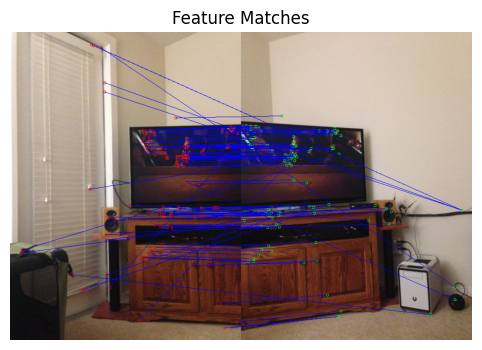

Step3 - Homography with RANSAC
Step4 - Warping images


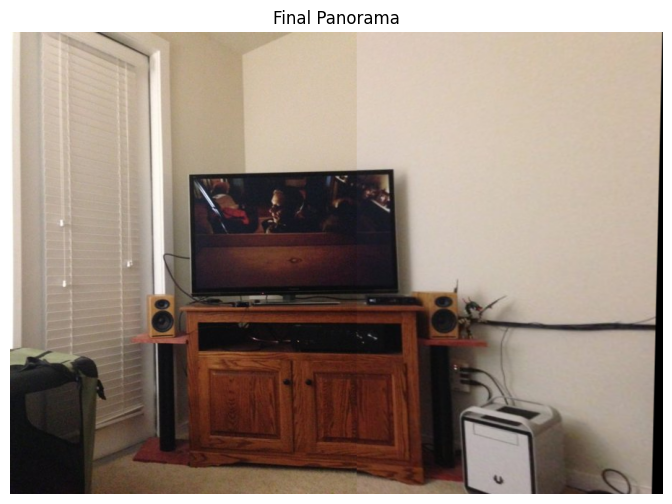

In [13]:
# ---------------------------------------------------------
# MAIN
# ---------------------------------------------------------
if __name__ == "__main__":
    src_path = "Automatic-Panorama-Stitching-Pipeline/img/"
    img_left = cv2.imread(src_path + "1.jpg")
    img_right = cv2.imread(src_path + "2.jpg")

    img_left = resize_for_colab(img_left)
    img_right = resize_for_colab(img_right)

    stitcher = Stitcher()
    panorama = stitcher.stitch([img_left, img_right])

    plt.figure(figsize=(12, 6))
    plt.title("Final Panorama")
    plt.imshow(panorama[:, :, ::-1])
    plt.axis("off")
    plt.show()

    os.makedirs("output", exist_ok=True)
    cv2.imwrite("output/panorama.jpg", panorama)
